Test if we can load our masks and image data in a way UNet can train with it

In [4]:
import numpy as np
import os
from tqdm import tqdm_notebook, tnrange
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import  tqdm
import cv2
from Scripts.Utility import Utility2
ut = Utility2()

def load_data(path):

    im_height = 256
    im_width = 256
    # for image
    image_path = path+"/Images"
    X = np.zeros((len(os.listdir("../"+image_path)), im_height, im_width, 1), dtype=np.float32)
    _X = ut.loadImages(image_path)
    _X = ut.grayscaleImages(_X)

    for i in range(len(_X)):
        #_X[i] = cv2.resize(_X[i],(256,256))
        _img = img_to_array(_X[i])
        x_img = resize(_img, (256, 256, 1))
        X[i, ..., 0] = x_img.squeeze() / 255

    # for masks
    mask_path = path+"/Masks"
    Y = np.zeros((len(os.listdir("../"+mask_path)), im_height, im_width, 1), dtype=np.float32)

    _Y = ut.loadImages(mask_path)
    _Y = ut.grayscaleImages(_Y)
    _Y = ut.thresholdImages(_Y)
    for i in range(len(_Y)):
        #Y[i] = cv2.resize(Y[i],(256,256))
        #Y[i] = Y[i].astype(np.float32)
        _img = img_to_array(_Y[i])
        y_img = resize(_img, (256, 256, 1))
        Y[i, ..., 0] = y_img.squeeze() / 255


    return X, Y

path_data = "/Data"
X, Y = load_data(path_data)



in init


In [5]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.15, random_state=2018)

In [6]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [7]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)

    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [8]:
input_img = Input((256, 256, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.15, batchnorm=True)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (A

In [9]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-dsb-cell.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [10]:
#old one
results = model.fit(X_train, y_train, batch_size=8, epochs=15, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))


Train on 326 samples, validate on 58 samples
Epoch 1/15
326/326 [==============================] - 17s 54ms/step - loss: 0.3976 - accuracy: 0.7847 - val_loss: 0.4296 - val_accuracy: 0.8082

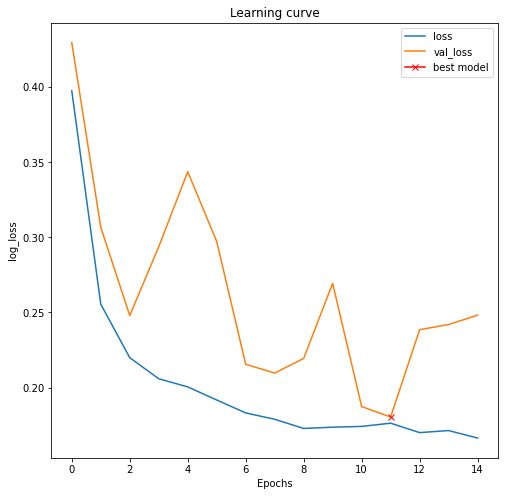

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [12]:
model.load_weights('model-dsb-cell.h5')

# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

58/58 [==============================] - 3s 55ms/step


[0.1804043809915411, 0.8141800165176392]

In [16]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
# Turns pixels to zero for non-cells and 1 for cells
preds_train_t = (preds_train > 0.01).astype(np.uint8)
preds_val_t = (preds_val > 0.01).astype(np.uint8)

58/58 [==============================] - 0s 5ms/step


In [31]:
import  random
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Cells')

    ax[1].imshow(y[ix].squeeze(), cmap='coolwarm')
    ax[1].set_title('Masks')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask: #colors='k',
        ax[2].contour(y[ix].squeeze(),  levels=[0.5], cmap='coolwarm')
    ax[2].set_title('Cells Predicted')

    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1,cmap='coolwarm')
    if has_mask: #colors='k',
        ax[3].contour(y[ix].squeeze(),  levels=[0.5])
    ax[3].set_title('Cells Predicted binary');


def plot_prediction(X,binary_preds, preds, ix=None):
    if ix is None:
        ix = random.randint(0,len(X))

    fig, ax = plt.subplots(1,3, figsize=(20,10))
    ax[0].imshow(X[ix, ...,0], cmap='seismic')
    ax[0].set_title('InputImage')

    ax[1].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1,cmap='binary')
    ax[1].set_title('Predicted Cells Binary Threshold')


    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1,cmap='binary')
    ax[2].set_title('Predicted Cells')

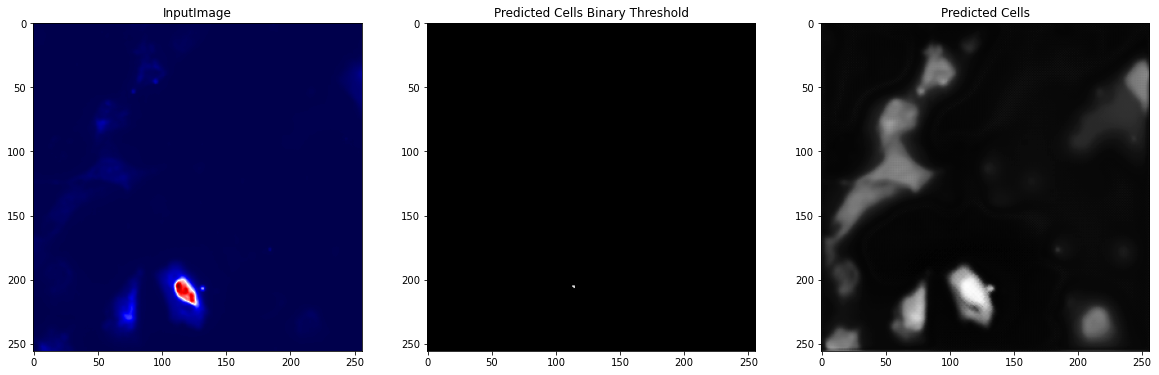

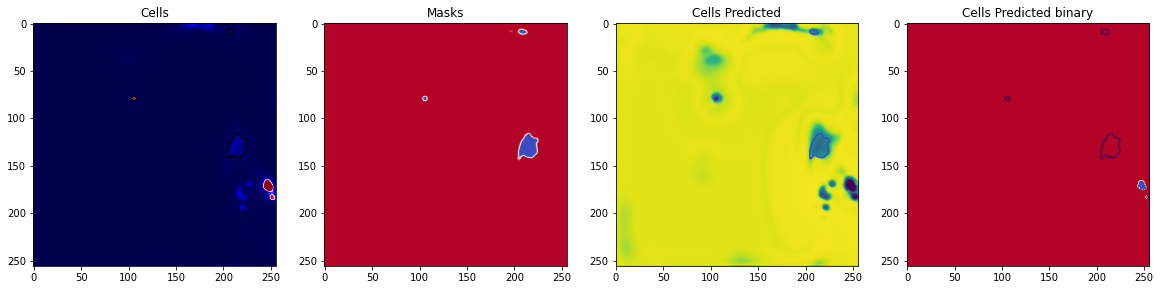

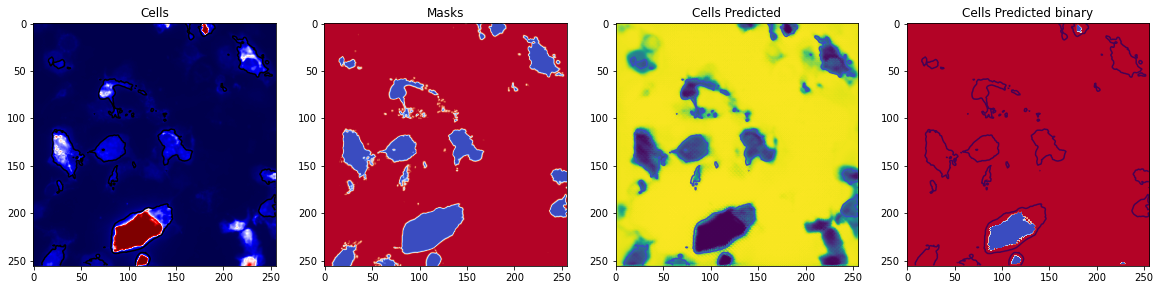

In [34]:
#Try out different colormaps to see the values
plot_prediction(X_train,preds_train_t, preds_train)

# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t)

# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t)